In [ ]:
import sys
import os
from pathlib import Path 
import pandas as pd

In [2]:
print(sys.version)

3.11.5 (main, Aug 24 2023, 15:09:45) [Clang 14.0.3 (clang-1403.0.22.14.1)]


In [3]:
in_kaggle = 'KAGGLE_USER_SECRETS_TOKEN' in os.environ
print(f"Running in Kaggle notebook? {in_kaggle}")

Running in Kaggle notebook? False


In [4]:
dir_path = Path('')
if in_kaggle: dir_path = Path('/kaggle/input/')

In [5]:
pd.read_csv

<function pandas.io.parsers.readers.read_csv(filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]', *, sep: 'str | None | lib.NoDefault' = <no_default>, delimiter: 'str | None | lib.NoDefault' = None, header: "int | Sequence[int] | None | Literal['infer']" = 'infer', names: 'Sequence[Hashable] | None | lib.NoDefault' = <no_default>, index_col: 'IndexLabel | Literal[False] | None' = None, usecols: 'list[HashableT] | Callable[[Hashable], bool] | None' = None, dtype: 'DtypeArg | None' = None, engine: 'CSVEngine | None' = None, converters: 'Mapping[Hashable, Callable] | None' = None, true_values: 'list | None' = None, false_values: 'list | None' = None, skipinitialspace: 'bool' = False, skiprows: 'list[int] | int | Callable[[Hashable], bool] | None' = None, skipfooter: 'int' = 0, nrows: 'int | None' = None, na_values: 'Sequence[str] | Mapping[str, Sequence[str]] | None' = None, keep_default_na: 'bool' = True, na_filter: 'bool' = True, verbose: 'bool' = False, skip_blan

In [6]:
# Read metadata file



data_paths = {
    'appliances':dir_path/'appliances',         
    'urban':dir_path/'urbansound8k'
}

meta2 = str(data_paths['urban']) + '/' + 'UrbanSound8K.csv'

meta1 = str(data_paths['appliances']) + '/' + 'appliances.csv'
df_UrbanSound = pd.read_csv(meta2)
df_Appliences = pd.read_csv(meta1)
#smpl = df_UrbanSound.classID.value_counts().max() / df_Appliences.classID.value_counts().min()
df_App_synth = df_Appliences.sample(frac=30, replace=True, random_state=1)
#df_UrbanSound = df_UrbanSound.sample(frac=(1/smpl), replace=True, random_state=1)

df_UrbanSound['relative_path'] = str(data_paths["urban"]) + '/fold' + df_UrbanSound['fold'].astype(str) + '/' + df_UrbanSound['slice_file_name'].astype(str)
df_Appliences['relative_path'] = str(data_paths["appliances"]) + '/' + df_Appliences['fold'].astype(str) + '/' + df_Appliences['slice_file_name'].astype(str)
df_App_synth['relative_path'] = str(data_paths["appliances"]) + '/' + df_Appliences['fold'].astype(str) + '/' + df_Appliences['slice_file_name'].astype(str)
df_App_synth["synth"] = True
#df = pd.concat([df_UrbanSound, df_Appliences, df_App_synth])
df = pd.concat([df_Appliences, df_App_synth])

df = df.reset_index(drop=True)
df.head()

#Take relative columns
df = df[['relative_path', 'classID', "synth", "class"]]
#df = df[['relative_path', 'classID']]

df.head()

,relative_path,classID,synth,class
0,appliances/training/1000000-11-0-0.wav,11,NaN,dehumidifier
1,appliances/training/1000004-11-0-0.wav,11,NaN,dehumidifier
2,appliances/training/1000012-11-0-0.wav,11,NaN,dehumidifier
3,appliances/training/1000024-11-0-0.wav,11,NaN,dehumidifier
4,appliances/training/1000040-11-0-0.wav,11,NaN,dehumidifier


In [7]:
print(df.classID.value_counts())

classID
11    598
10    510
12    349
Name: count, dtype: int64


In [8]:
from numpy import random
import numpy as np
import torch
import torchaudio
from torchaudio import transforms
from torchaudio.io import AudioEffector
import matplotlib.pyplot as plt

class AudioUtil():
    #---------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    #---------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        #sig, sr = torchaudio.load(audio_file)
        
        return (sig, sr)

    @staticmethod
    def apply_gain(aud, sig_max=0.9):
        sig, sr = aud
        gn = sig_max / sig.max()

        transform = transforms.Vol(gain=gn, gain_type="amplitude")
        
        sig_amp = transform(sig)
        
        return (sig_amp, sr)
    
    #---------------
    # Convert soundfile to desired number of channels
    #---------------
    @staticmethod
    def rechannel(aud, new_channel):
        
        sig, sr = aud
        
        if sig.shape[0] == new_channel:
            #Nothing todo
            return aud
        
        if (new_channel == 1):
            #Convert stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            #Convert from mono to sterio by duplicating the first channel
            resig = torch.cat([sig,sig])
        return ((resig, sr))
    
    #---------------
    #Resample to make sure samplerate is the same for all files - resample applies to one channel at a time
    #---------------
    @staticmethod
    def resample(aud, newsr):
        
        sig, sr = aud
        
        if (sr == newsr):
            #do nothing
            return aud
        
        num_channels = sig.shape[0]
        
        #resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        
        if (num_channels > 1):
            #Resample the second channel and merge both
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
            
        return ((resig, newsr))
    
    
    #-----------------
    #Pad or turncate the signal to be off a standard length in milliseconds
    #-----------------
    @staticmethod
    def pad_trunc(aud, max_ms):

        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms
        
        if (sig_len > max_len):
            #Turncate the signal to the given length
            sig = sig[:,:max_len]
        elif (sig_len < max_len):
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len
            
            #pad with zeroes
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        return (sig, sr)

    #--------------------
    #Shift the signal by a random bit, end of signal is wrapped around 
    #to beginning
    #--------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    #--------------------
    #Add eccho or vibrato to the signal. 
    #This method is intented for the generation of synthetic data,
    #using a limited dataset. 
    #--------------------
    @staticmethod
    def add_rand_effect(aud):
        sig, sr = aud    
        effect = random.randint(0,1)
        if effect ==0:
            delay = random.randint(40,100)
            decay = round(random.uniform(0.2,0.7), 2)
            effect = "aecho=in_gain=0.8:out_gain=0.9:delays={}:decays={}".format(delay, decay)
        elif effect == 1:
            freq = random.randint(9,15)
            decay = round(random.uniform(0.15,0.4), 2)
            effect = "vibrato=f={}:d={}".format(freq, decay)
        effector = AudioEffector(effect=effect, pad_end=False)
        sig_ef = effector.apply(sig.T, int(sr)) # int(sr)
        sig_ef = sig_ef.T

        return (sig_ef, sr)
    
    #----------------------------------
    #Genetate spectrogram
    #----------------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80
        
        #spec has shape [channel, n_mels, time]
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
        
        #convert to db
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        
        return spec
    
    
    #Augment the spectrogram by masking out some sections of it in both the frequency
    #dimencion (Horizontal) and the time dimension (vertical bars)
    
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec
        
        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
        
        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
        
        return np.absolute(aug_spec) # Jonas added np.absolute
    
        

In [9]:
from torch.utils.data import DataLoader, Dataset, random_split
#----------------
#Sound dataset
#----------------
    
class SoundDS(Dataset):
    def __init__(self, df, data_paths):
        self.df = df
        self.data_paths = data_paths
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4
    
    #------------------
    #Number of items in dataset
    #------------------
    def __len__(self):
        return len(self.df)

    #------------------
    #Get i'th item in dataset
    #------------------
    def __getitem__(self, idx):

        # Get the class ID  
        class_id = self.df.loc[idx, 'classID']
        audio_file = str(self.df.loc[idx, 'relative_path'])
        aud = AudioUtil.open(audio_file)
        gain_aud = AudioUtil.apply_gain(aud)
        if self.df.loc[idx, 'synth'] == True:
            gain_aud = AudioUtil.add_rand_effect(gain_aud)
        reaud = AudioUtil.resample(gain_aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)
        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
        return aug_sgram, class_id


In [10]:
# Splitt data for training and validation

myds = SoundDS(df, data_paths) #returns spectrogram and classID
#Random split between training and validation data

num_items = len(myds)
num_train = round(num_items*0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)


In [11]:
import torch.nn.functional as F
from torch.nn import init
from torch import nn

#---------------------------
# Audio Classification Model
#---------------------------
class AudioClassifier (nn.Module):
    #---------------------------
    #Build the model architecture
    #---------------------------
    
    def __init__(self):
        super().__init__()
        conv_layers = []
        
        #First convolution block with Relu and Batch Norm. Use Kaiming Initialisation
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        #Second convolution block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]
        
        #Third convolution block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        #Fourth convolution block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4] 
        
        # Linear classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=df.classID.max()+1) #Changed Jonas out_features
        
        # Wrap the convolutional blocks
        self.conv = nn.Sequential(*conv_layers)
    
    #-------------------------
    #Forward pass computations
    #-------------------------
    def forward(self, x):
        # Run convolutional blocks
        x = self.conv(x)
        
        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        
        # Linear layer
        x = self.lin(x)
        
        # Final output
        
        return x

# Create the model and put it on the GPU if available
myModel =  AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
#Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

In [12]:

#-------------------
#Training loop
#-------------------
def training(model, train_dl, num_epochs):
    #Loss function optimiser and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=0.001,
                                                    steps_per_epoch=int(len(train_dl)),
                                                    epochs=num_epochs,
                                                    anneal_strategy='linear')
    
    #Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        
        #repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            # Get the input features and target labels and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            
            #Normalise the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            #Zero prameter gradients
            optimiser.zero_grad()
            
            #Forward + backward + optimise
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            scheduler.step()
            
            #Keep stats for Loss and Accuracy
            running_loss += loss.item()
            
            
            #Get predicted class with highest score
            _, prediction = torch.max(outputs, 1)
            # Count the predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
            #if i % 10 == 0: #
            #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
        
        #Print stats at the end of each epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')
    
    print('Finished Training')
    
num_epochs = 1
training(myModel, train_dl, num_epochs)
    

Epoch: 0, Loss: 1.53, Accuracy: 0.77
Finished Training


In [13]:

#-------------------
#Inferrence
#-------------------

def inferrence (model, v_dl):
    correct_prediction = 0
    total_prediction = 0
    
    classIDs = sorted(list(df.classID.unique()))
    df_metr = pd.DataFrame({'classIDs': classIDs,
                        'correct_pred': np.zeros(len(classIDs)),
                        'false_pred': np.zeros(len(classIDs)),
                        'accuracy': np.zeros(len(classIDs))})
    df_metr = df_metr.set_index('classIDs')
    
    #Disable gradient updates
    with torch.no_grad():
        for data in v_dl:
            # Get the input features and target labels and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)
            #Normalise the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s
            
            #Get predictions
            outputs = model(inputs)
            
            #Get predicted putputs with highest score
            i, prediction = torch.max(outputs,1)
            for n in range(len(outputs)):
                if labels[n].item() == -1:
                    print("Predicted class:{}, score:{}, actual class:{}".format(prediction[n].item(), outputs[n].max().item(), labels[n].item()))
                else:
                    if prediction[n].item() == labels[n].item():
                        df_metr['correct_pred'].loc[prediction[n].item()] += 1
                    else:
                        df_metr['false_pred'].loc[prediction[n].item()] += 1
                #print("Predicted class:{}, score:{}, actual class:{}".format(prediction[n].item(), outputs[n].max().item(), labels[n].item()))
            #print(outputs[15].max(),prediction[15], labels[15])
            #Count of predictions that matched target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            
    acc = correct_prediction / total_prediction
    df_metr['accuracy'] = df_metr['correct_pred'] / (df_metr['correct_pred'] + df_metr['false_pred'])
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
    return df_metr, outputs

    


#Run inferrence on trained model with validation set
#inferrence(myModel, val_dl)


In [15]:
d = inferrence(myModel, val_dl)
              

Accuracy: 0.94, Total items: 291


In [16]:
print(d)

(          correct_pred  false_pred  accuracy
classIDs                                    
10                91.0         0.0  1.000000
11               110.0         9.0  0.924370
12                73.0         8.0  0.901235, tensor([[ 0.4918,  0.2896,  0.4639,  0.2394,  0.5193,  0.5775,  0.3749,  0.1751,
          0.4130,  0.5300, -0.5076, -2.0494,  2.8189],
        [-0.2644, -0.2407, -0.3465, -0.2230, -0.4010, -0.0827, -0.3090, -0.0076,
         -0.0647, -0.4758,  0.1613,  1.0654, -0.7297],
        [-0.5410, -0.6465, -0.3471, -0.3415, -0.4989, -0.4105, -0.4427, -0.4325,
         -0.3620, -0.6209,  0.9123,  1.4374, -1.7788]]))


In [17]:
meta3 = str(data_paths['appliances']) + '/test/' + 'test.csv'
df_test = pd.read_csv(meta3)
#df_test = df_test.sample(frac=150, replace=True, random_state=1)
df_test = df_test.reset_index(drop=True)
df_test['relative_path'] = 'appliances/' + df_test['fold'].astype(str) + '/' + df_test['slice_file_name'].astype(str)
df_test['synth'] = False
df_test = df_test[['relative_path', 'classID', 'synth']]

#df_test2 = 

#Onedrive_postdoc/OneDrive - University of Exeter/sound_recognition/appliances/test/9000028-11-0-0.wav

In [18]:
print(df_test)

                        relative_path  classID  synth
0  appliances/test/9000000-11-0-0.wav       11  False
1  appliances/test/9000003-11-0-0.wav       11  False
2  appliances/test/9000009-11-0-0.wav       11  False
3  appliances/test/9000018-11-0-0.wav       11  False
4  appliances/test/9000019-11-0-0.wav       11  False
5  appliances/test/9000022-11-0-0.wav       11  False
6  appliances/test/9000028-11-0-0.wav       11  False
7  appliances/test/9000044-12-0-0.wav       10  False


In [19]:
ds_test = SoundDS(df_test, data_paths)
test_dl = torch.utils.data.DataLoader(ds_test, batch_size=8, shuffle=False)

In [20]:


d, output = inferrence(myModel, test_dl)
d2 = d.head()
d2

print(d)
#print(output)

Accuracy: 0.50, Total items: 8
          correct_pred  false_pred  accuracy
classIDs                                    
10                 1.0         2.0  0.333333
11                 3.0         0.0  1.000000
12                 0.0         2.0  0.000000


Accuracy: 0.62, Total items: 8


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'air_conditioner'),
  Text(1, 0, 'car_horn'),
  Text(2, 0, 'children_playing'),
  Text(3, 0, 'dog_bark'),
  Text(4, 0, 'drilling'),
  Text(5, 0, 'engine_idling'),
  Text(6, 0, 'gun_shot'),
  Text(7, 0, 'jackhammer'),
  Text(8, 0, 'siren'),
  Text(9, 0, 'street_music'),
  Text(10, 0, 'lesker_system'),
  Text(11, 0, 'dehumidifier'),
  Text(12, 0, 'gas_boiler')])

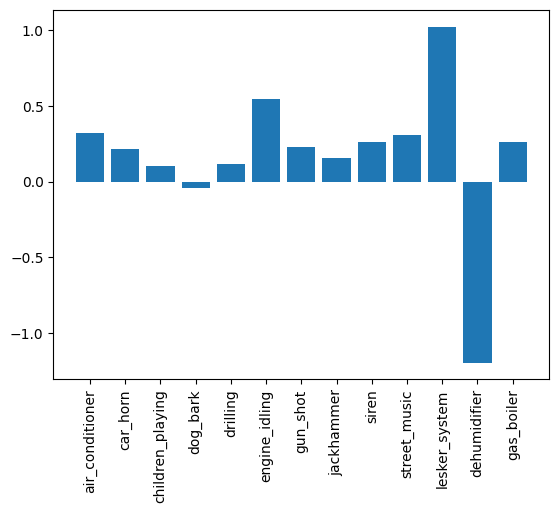

In [21]:
d, output = inferrence(myModel, test_dl)
d2 = d.head()
#d2

#0 = air_conditioner
#1 = car_horn
#2 = children_playing
#3 = dog_bark
#4 = drilling
#5 = engine_idling
#6 = gun_shot
#7 = jackhammer
#8 = siren
#9 = street_music
classes = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music", "lesker_system", "dehumidifier", "gas_boiler"]
ax = plt.bar(classes, output[7])
plt.xticks(rotation='vertical')

tensor(0.0908)
tensor(9.9130)


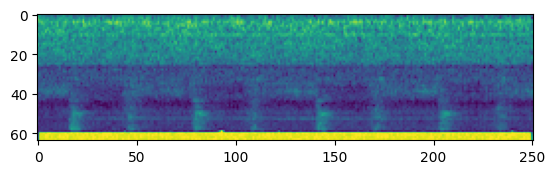

In [22]:
import IPython.display as display
from IPython.display import Audio


audio_file = "appliances/training/2000024-10-0-0.wav"
aud = AudioUtil.open(audio_file)
wv, sr = aud

print(wv.max())
gn = 0.9 / wv.max()
print(gn)

transform = transforms.Vol(gain=gn, gain_type="amplitude")
quiet = transform(wv)
quiet = quiet, sr
mel = AudioUtil.spectro_gram(quiet)

np_spec = np.absolute(mel.numpy())
imgplot = plt.imshow((np_spec[0,:,:]))

In [ ]:
#Each file should have the format matching the example ie
#100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark

#slice_file_name,   fsID,   start, end,       salience, fold, classID, class
#100032-3-0-0.wav,  100032, 0.0,   0.317551,  1,        5,    3,       dog_bark
#1000000-11-0-0.wav 1000000 0.0,   0.0        0,        11,   11,      lesker_normal

def split_recording(audio_file, class_name, classID, directory, metadata, split_length=3):
    
    sig, sr = torchaudio.load(audio_file)
    _, sig_len = sig.shape
    length = sig_len / sr # length seconds
    if os.path.isfile(metadata) == True:
        df_temp = pd.read_csv(metadata)
        d = df_temp.loc[(df_temp['classID'] == classID)]
        fsid = int(d['fsID'].max()) + split_length
    else:
        fsid = 9000000

    for i in range(0, round(length), split_length):
        fsid = fsid + i
        split_fn = str(fsid) + '-' + str(classID) + '-0-0.wav'
        csv_entry = {
            'slice_file_name' : [str(split_fn)],
            'fsID' : [fsid],
            'start': [float(i)],
            'end' : [float((i) + split_length)],
            'salience' : [0],
            'fold' : [directory],
            'classID' : [classID],
            'class' : [class_name]
        }
        df = pd.DataFrame(csv_entry)
        if os.path.isfile(metadata) == True: 
            df.to_csv(metadata, mode='a', index=False, header=False)
        else:
            df.to_csv(metadata, mode='a', index=False, header=True)


        split_start = i * sr
        split_end = split_start + split_length * sr
        sig = sig[:, split_start : split_end]
        torchaudio.save(directory + '/' + split_fn, sig, sr)



In [ ]:
file = 'appliances/test/dehumidifier1.wav'
dir = 'appliances/test/test/'
class_name = 'dehum'
classID = 33
meta = "test2.csv"
split_recording(file, class_name, classID, dir, dir + meta)